# EXPLORATORY DATA ANALYSIS

## Preparations and Loading Data

In [1]:
import operator
import math
import functools
import seaborn
import scipy.io
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.tsa.arima_model import ARMA, ARIMA, ARIMAResults
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.api import qqplot

Before EDA, we will need the following function to generate the coefficients for differencings. Notice that first order differencing is given by $dA_t = A_t-A_{t-1}$. So for the input n=1, the output will be [1,-1]. Similarly, it is easy to obtain that the second order differencing formula $d^2A_t=A_t-2A_{t-1}+A_{t-2}$. And thus for the input n=2, the function outputs [1, -2, 1]. So on and so forth. 

In [2]:
# Order 1 differencing
def diff(arr):
    return [(arr[i+1]-arr[i]) for i in range(len(arr)-1)]

In [3]:
# Generation of coefficients in high order differencings
def generateCoeffs(n):
    if n == 0:
        return [1]
    
    coeff = [1, 1]
    i = 1
    
    while i < n:
        new_coeff = [1]
        
        for j in range(len(coeff)-1):
            new_coeff.append(coeff[j]+coeff[j+1])
        new_coeff.append(1)
        coeff = new_coeff
        i += 1
        
    return [coeff[i]*((-1)**i) for i in range(n+1)]   

In [4]:
# Mean Square Error
def MSE(true, predicted):
    return functools.reduce(operator.add, map(lambda x,y: (x-y)**2, true, predicted))/len(true)

In [6]:
# loop through all files to extract ROI time-series from each patients
subjects = []

for i in range(1,143):
    fileName = 'sub_'+str(i)+'.mat'
    file = scipy.io.loadmat(fileName)
    subjects.append(file['tc_filt'])  
    

Next we use Augmented Dickey-Fuller Test on stationarity. It is a test on whether the process is a unit-root process. An easy observation is that unit-root series are not stationary. In particular, for AR(1) process, if it has a unit root, then the variance grow linearly with time. Here null hypothesis is that the series has a unit (thus non-stationary). 

In the test, we consider 95% confidence level. To reject null hypothesis and conclude that series is stationary, the statistics need to be above significance level, in this case given by test[0].

The following section continues to run differencing until all regions of all subjects get to perfect stationarity.

## Differencings and Stationarity

In [8]:
# sttnry_map[k] stores stationary map for the kth order differencing
sttnry_map = []
# sttnry_roi_counts[k][l] stores the number subjects that have l stationary ROI's after k differencings
sttnry_roi_counts = [] 
# all_subject_perfect determines whether after differencings all ROI's of all subjects become stationary
all_perfect = False
# initlaize number or differencing needed to make perfect stationarity
d = -1
# diff_needed_for[subject][region] takes down the number of differencings needed to stationarize the corresponding region 
# a subject
diff_needed_for = [[-1 for _ in range(160)] for _ in range(142)]
# all_stationary is a flag to signal the stop of the loop, when all regions of all patiens become stationary
all_stationary = False

In [ ]:
while not all_stationary:
    d += 1
    this_order_sttnry_map = []
    this_order_sttnry_roi_counts = []
    coeff = generateCoeffs(d)
    for sub in range(len(subjects)):
        count = 0
        sub_sttnry = []
    
        for region in range(len(subjects[sub][0])):
            if diff_needed_for[sub][region] == -1: # not yet stationarized
                df = []
                for t in range(len(subjects[sub]) - d):
                    temp = 0
                
                    for i in range(d+1):
                        temp += subjects[sub][t + d-i, region]*coeff[i]
                    df.append(temp)
                
                ADF_test = adfuller(df)
        
                if ADF_test[4]['5%'] > ADF_test[0]:  
                    sub_sttnry.append(1)
                    count += 1
                    diff_needed_for[sub][region] = d
                else:
                    sub_sttnry.append(0)
            else:
                sub_sttnry.append(1)
                count += 1
                    
        this_order_sttnry_roi_counts.append(count) 
        this_order_sttnry_map.append(sub_sttnry)
        
    all_stationary = all([count ==160 for count in this_order_sttnry_roi_counts])
    sttnry_map.append(this_order_sttnry_map)
    sttnry_roi_counts.append(this_order_sttnry_roi_counts)

Check the number of differencings needed to get everything stationarized.

In [224]:
print("It takes "+str(len(sttnry_map))+" differencings to get perfect stationarity across all regions and all subjects.")

It takes 7 differencings to get perfect stationarity across all regions and all subjects.


### Examine Paterns in Certain Order of Differencing

In [1]:
diff = 3

In [2]:
plt.hist(sttnry_roi_counts[diff],20)
plt.title('Order '+str(diff)+' Differencing')
plt.xlabel('Number of Stationary Regions')
plt.ylabel('Number of Subjects')
plt.show()

NameError: name 'plt' is not defined

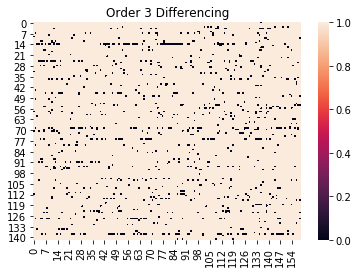

In [408]:
seaborn.heatmap(sttnry_map[diff])
plt.title('Order '+str(diff)+' Differencing')
plt.show()

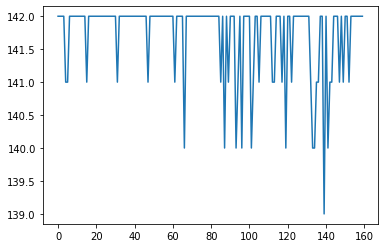

In [410]:
region_sum = [0 for _ in range(len(sttnry_map[1][0]))]
for region in range(len(sttnry_map[1][0])):
    for subject in range(len(sttnry_map[1])):
        region_sum[region] += sttnry_map[4][subject][region] 
plt.plot(region_sum)
plt.show()

Extract the most non-stationary subjects after 1st differencing for further inspection.

It seems that we are finally done! However, we still have to do a sanity check. Take the last ROI of the last subject for inspection. 

### Over-differencing

In [291]:
# testing ARIMA pipeline on a sample time-series: the 160-th ROI of subject 142
sample_ts = df

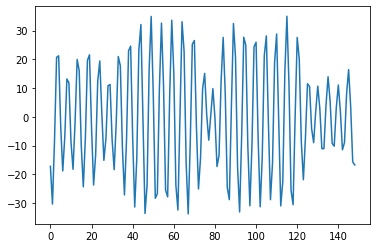

In [292]:
# Take a look at the 7th order differenced signal. 
plt.plot(sample_ts)
plt.show()

In [293]:
corr = np.correlate(sample_ts,sample_ts,mode='full')
corr = corr[len(corr)//2:]/max(corr)
print(corr)
print("The Lag-1 auto-correlations is " +str(corr[1]))

[ 1.          0.35231684 -0.73468082 -0.8405193   0.14284632  0.89950651
  0.45183316 -0.5664631  -0.794409    0.0379062   0.78765496  0.46001212
 -0.47308512 -0.74490884 -0.00862116  0.72204814  0.46487304 -0.41319103
 -0.71804158 -0.05046353  0.67279389  0.47735848 -0.35680649 -0.69520694
 -0.09122447  0.62488383  0.48635718 -0.30561317 -0.67276922 -0.12736905
  0.58031432  0.49383715 -0.25621299 -0.64593814 -0.15485244  0.53777264
  0.48842561 -0.22846086 -0.63050985 -0.16779853  0.53085381  0.51285665
 -0.20575626 -0.65887572 -0.23158122  0.51123387  0.58040711 -0.11656326
 -0.65661543 -0.33208774  0.41818442  0.60597843  0.00262996 -0.58111494
 -0.38722837  0.29988673  0.56357826  0.07943525 -0.48397313 -0.38430716
  0.21593205  0.5026705   0.11179301 -0.40959124 -0.36549003  0.1614911
  0.45226659  0.13107532 -0.35037971 -0.3467367   0.1161827   0.4038235
  0.14197243 -0.29634473 -0.31896656  0.08654521  0.35945892  0.13806207
 -0.26307933 -0.29825889  0.06987148  0.33604136  0.1

The Lag-1 correlation is positive, which is a good sign. Lets take a closer look on the ACF plot.

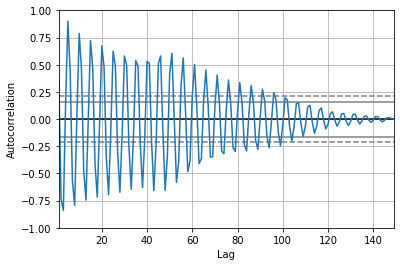

In [275]:
sample_ts = pd.DataFrame(sample_ts)
pd.plotting.autocorrelation_plot(sample_ts)
plt.show()

Now we have a problem. The autocorrelation quickly steps into far negative zone and oscillate all the way through. This simply means that this time-series is over-differenced. It is very possible that a lot of the other time-series are also over-differenced. What is the consequence of having it over-differenced? Basically we lost all the ARIMA features and are left with useless stuff. This means that we cannot blindly difference the series until it hit stationarity beacause this will naturally lead to over-differencing. 

## Making One Sample Prediction

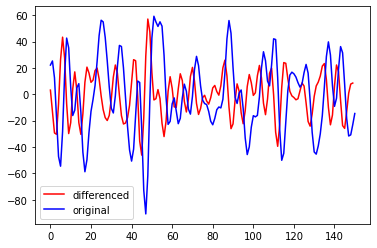

In [17]:
whole_ts = subjects[0][:,1]
ts = whole_ts[:-5] # extracting the region 1 of the first subject 
diff_ts = diff(ts)
plt.plot(diff_ts, color = 'r',label='differenced')
plt.plot(ts, color = 'b', label='original')
plt.legend()
plt.show()

### Choosing The Right Orders

The orthodoxical way of choosing the correct $(p,d,q)$ is by inspection and trial-and-error. Usually by looking at the autocorrelation plot one can extract features of the time-series that informs us on the choice of $(p,q)$. Sometimes, when the time series is over-differenced or underdifferenced, we can tweak the order or $p,q$ to compensate that. But in general, we want to use as little differencings as possible to preserve the characters of the time-series.

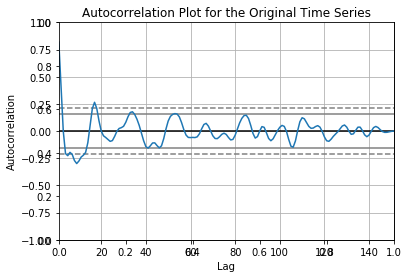

In [19]:
ts = pd.DataFrame(ts)
plt.title('Autocorrelation Plot for the Original Time Series')
pd.plotting.autocorrelation_plot(ts)
plt.show()

We can tell from the plot already that the series is non-stationary as the auto-correlation immediate drops to negative region. To be more specific, we run a test to confirm this observation.

In [21]:
test = adfuller(ts)
if test[4]['5%'] > test[0]:
    res = 'stationary'
else:
    res = 'non-stationary'
print('This particular time series is ' + res)

ValueError: too many values to unpack (expected 2)

Now, lets difference. 

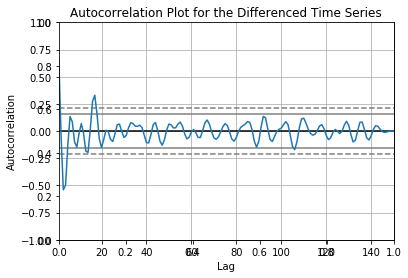

In [22]:
diff_ts = pd.DataFrame(diff_ts)
plt.title('Autocorrelation Plot for the Differenced Time Series')
pd.plotting.autocorrelation_plot(diff_ts)
plt.show()

The autocorrelation plot for the differenced signal indicates that the series is overdifferenced, as the plot quickly dive down to the far negative zone (<0.5). So we will not perform any differencing before testing out the ARIMA models. Based on the autocorrelation plot, it seems that we only need $p=1$, but since we choose not to difference to make stationarity, we also consider $p=2,3$ as a compensation. Next we try to fit ARIMA(1,0) and ARIMA(2,0) and see how they compare. 

In [23]:
arima_1_0_0 = ARIMA(ts, order=(1,0,0)).fit()
arima_2_0_0 = ARIMA(ts, order=(2,0,0)).fit()
arima_3_0_0 = ARIMA(ts, order=(3,0,0)).fit()

Akaike Information Criterion (AIC) provides a comparison between the two arma model to the hidden true model (which we don't know). In priciple the smaller the score the higher the probability that the model is the true one. 

In [31]:
print("The AIC and BIC scores for ARIMA(3,0,0) model are respectively: "+str(arima_3_0_0.aic)+' , '+str(arima_3_0_0.bic))
print("The AIC and BIC scores for ARIMA(2,0,0) model are respectively: "+str(arima_2_0_0.aic)+' , '+str(arima_2_0_0.bic))
print("The AIC and BIC scores for ARIMA(1,0,0) model are respectively: "+str(arima_1_0_0.aic)+' , '+str(arima_1_0_0.bic))


The AIC and BIC scores for ARIMA(3,0,0) model are respectively: 989.3471409571678 , 1004.4335401412424
The AIC and BIC scores for ARIMA(2,0,0) model are respectively: 1113.8536298002664 , 1125.922749147526
The AIC and BIC scores for ARIMA(1,0,0) model are respectively: 1286.1447306819737 , 1295.1965701924184


### Checking Assumptions or ARIMA

We will choose the ARIMA(3,0,0) model which has a smaller AIC score. Now take a look at the residual plot. Ideally, we should want it to normally distributed. 

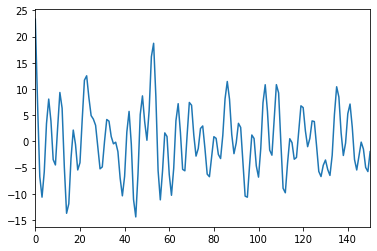

In [25]:
arima_3_0_0.resid.plot()
plt.show()

It seems fine. Now to confirm that lets plot quantile-quantile plot (qq-plot) against the nornal distribution. 

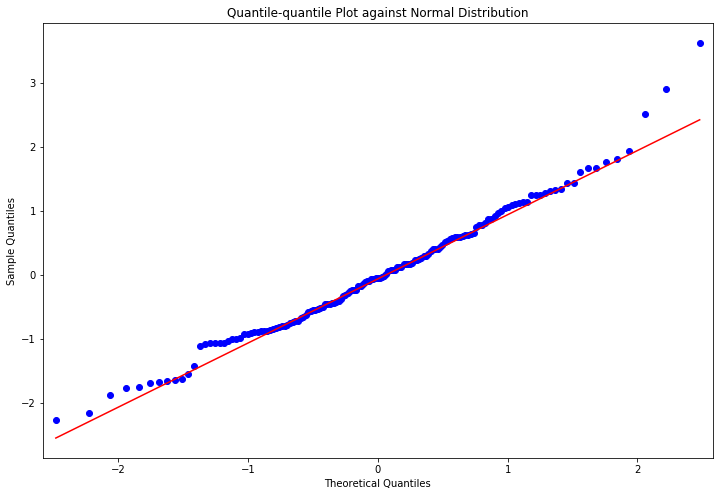

In [26]:
fig = plt.figure(figsize=(12,8))
resid = arima_3_0_0.resid
ax = fig.add_subplot(111)
fig = qqplot(resid, line='q', ax=ax, fit=True)
plt.title("Quantile-quantile Plot against Normal Distribution")
plt.show()

The residuals look healthily distributed, meaning that the fitted model actually satisfies the assumption of the model (this sounds a little cyclic but is the best we can get). Lets take a look at the fit. 

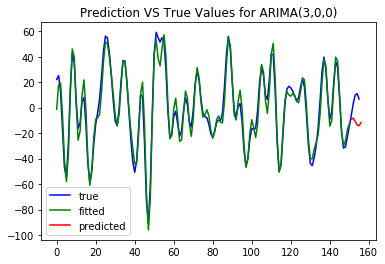

In [33]:
plt.plot(whole_ts, color='b', label='true')
fitted_3_0_0 = arima_3_0_0.predict()
predict_3_0_0 = arima_3_0_0.predict(start=151, end=156)
plt.plot(fitted_3_0_0, color='g',label='fitted')
plt.plot(predict_3_0_0, color='r', label='predicted')
plt.title("Prediction VS True Values for ARIMA(3,0,0)")
plt.legend()
plt.show()

In [35]:
print('The mean squared error for ARIMA(3,0,0) is: '+str(MSE(whole_ts[-5:],predict_3_0_0)))

The mean squared error for ARIMA(3,0,0) is: 322.2694494307914


The fit is very good yet the prediction is poor. Surprisingly ARIMA(2,0,0) for this time series provides a similar fit but much better prediction.

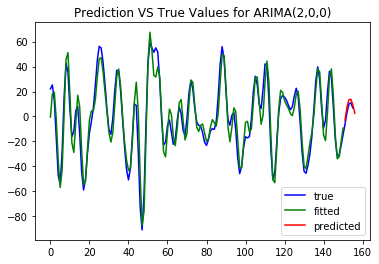

In [34]:
plt.plot(whole_ts, color='b', label='true')
fitted_2_0_0 = arima_2_0_0.predict()
predict_2_0_0 = arima_2_0_0.predict(start=151, end=156)
plt.plot(fitted_2_0_0, color='g',label='fitted')
plt.plot(predict_2_0_0, color='r', label='predicted')
plt.title("Prediction VS True Values for ARIMA(2,0,0)")
plt.legend()
plt.show()

In [36]:
print('The mean squared error for ARIMA(2,0,0) is: '+str(MSE(whole_ts[-5:],predict_2_0_0)))

The mean squared error for ARIMA(2,0,0) is: 11.21270406159864


## Predictions for Bulk

Now that we have a pipeline running for a single test region of one subject, we can move on tackle all regions of all subjects.

Recall that we have the 2D array diff_needed_for[][] from above which stores the differencings needed for certain region of a certain subject to reach stationarity. This information could be used to determine the right order of $d$. But now lets us assume that we always choose $d=0$ and we fit ARIMA models with $p=1,2,3, q=1,2,3$ and pick out the best based on AIC. 

In [39]:
# models = models[subject][region] stores the opimal models based on AIC
models = [[None for _ in range(len(subjects[0][1]))] for _ in range(len(subjects))]
# MSEs = MSEs[subject][region] stores the mean square error for the corresponding models
MSEs = [[None for _ in range(len(subjects[0][1]))] for _ in range(len(subjects))]
# print(len(models))
# print(len(models[0]))

D:\anaconda\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
D:\anaconda\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
D:\anaconda\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
D:\anaconda\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
D:\anaconda\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
D:\anaconda\lib\site-packages\

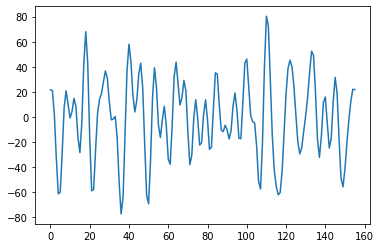

In [40]:
d = 0 # for now fix d

for sub in range(10):
    for region in range(10):
        ts = subjects[sub][:,region]
        truncated = pd.DataFrame(ts[:-5])
        order = (0,0,0) 
        cur_min_AIC = math.inf
        for p in range(1,5):
            for q in range(0,5):
                try:
                    model = ARIMA(truncated, order=(p,d,q)).fit()
                    if model.aic < cur_min_AIC:
                        order = (p,d,q)
                except ValueError:
                    continue
        
        if order != (0,0,0):
            models[sub][region] = model
            predicted = model.predict(start=151, end=156)
            true = ts[-5:]
            MSEs[sub][region] = MSE(true, predicted)
        
plt.plot(subjects[sub][:,region])
plt.show()

In [41]:
print(MSEs)

[[298.7293325685176, 322.2694494307914, 77.19700889735091, 321.07239258628573, 325.6210507125739, 782.28794919945, 96.74893497112183, 27.773232355639674, 176.03476359015434, 370.9179860294954, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, Non